In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u"]#,"g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

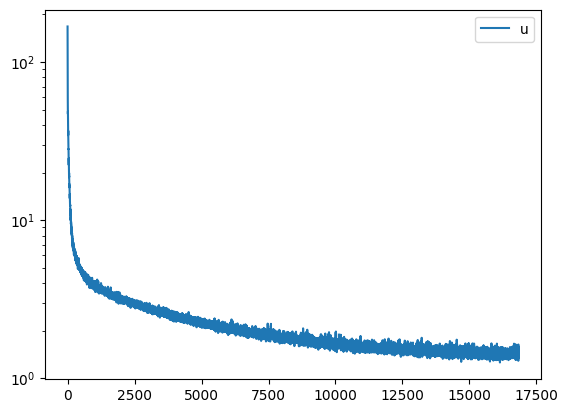

In [3]:
i = 0
for x in loss_bands:
    plt.plot(x, label=bands[i])
    i+=1

plt.yscale("log")
plt.legend()

1.5730143785476685


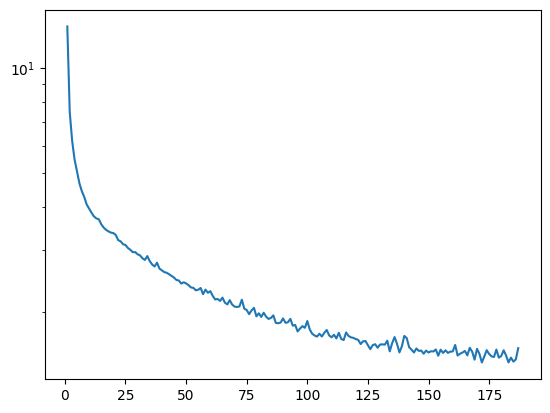

In [4]:
i = 0
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

def cut(z):
    return 10**(z+4)

band = 0

z = sps_params_train[:, 0]
mass = sps_params_train[:, -1]
mag = phot_train[:, band]

inds = np.where(mass > cut(z))[0]

sps_params_train = sps_params_train[inds]
phot_train = phot_train[inds]


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


971681
total outliers:  91.5291129496203


(1e-32, 1e-23)

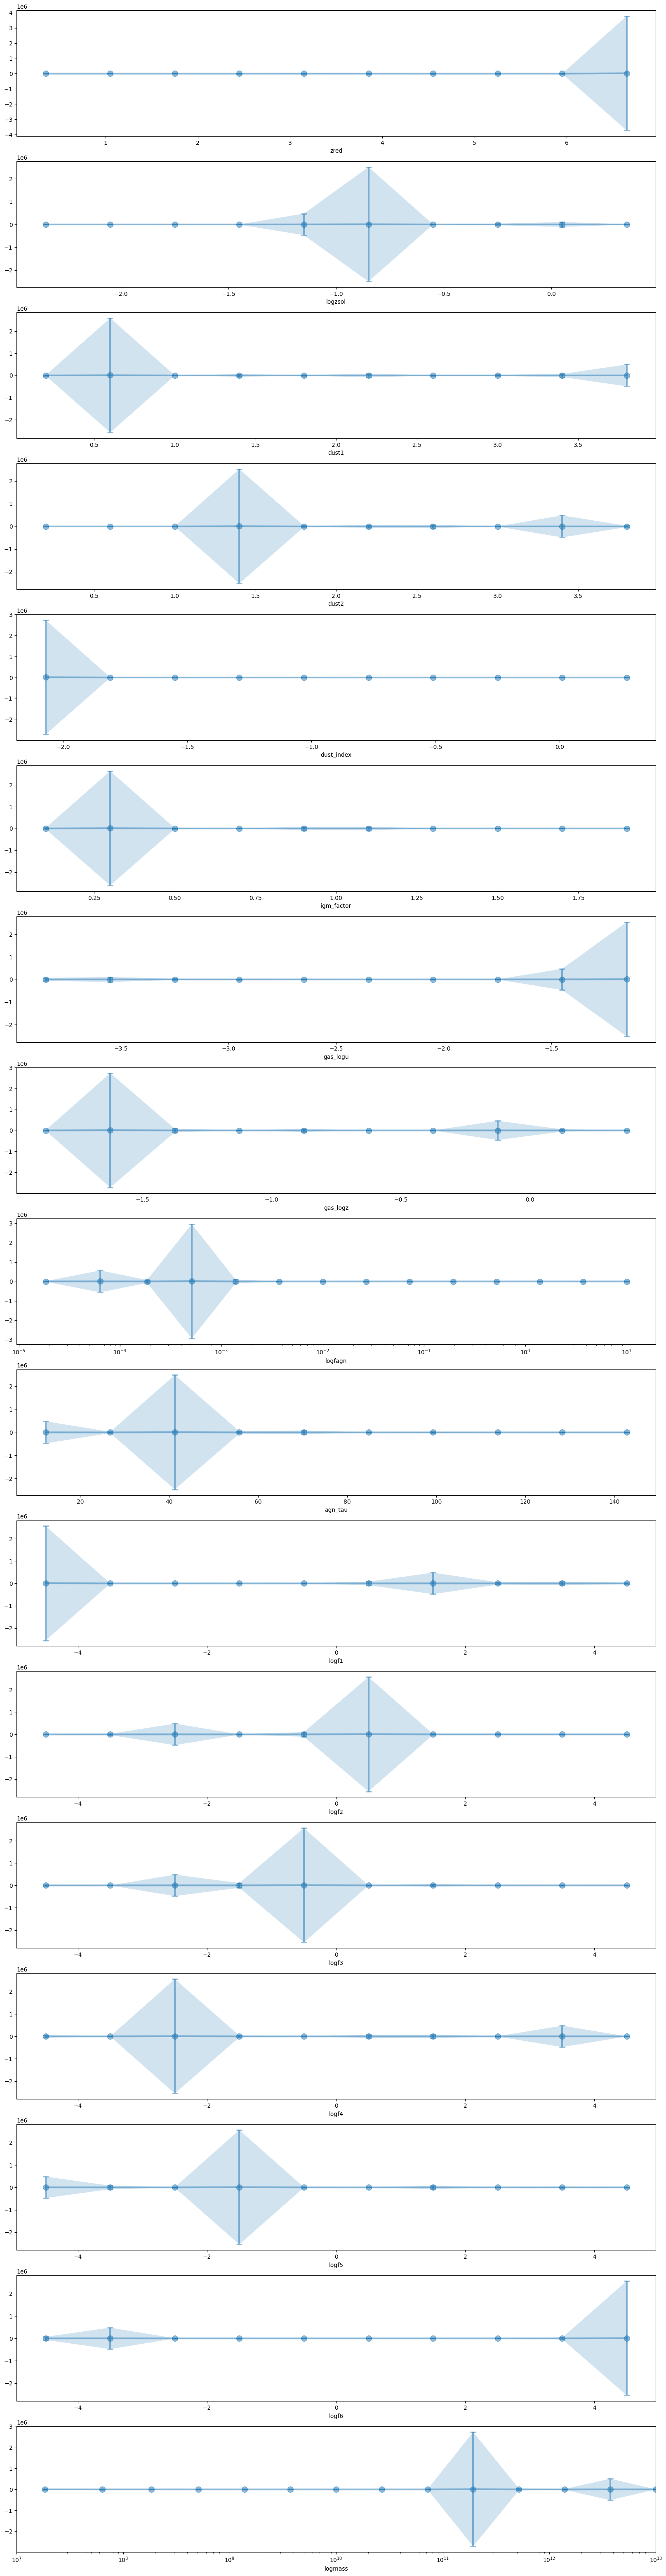

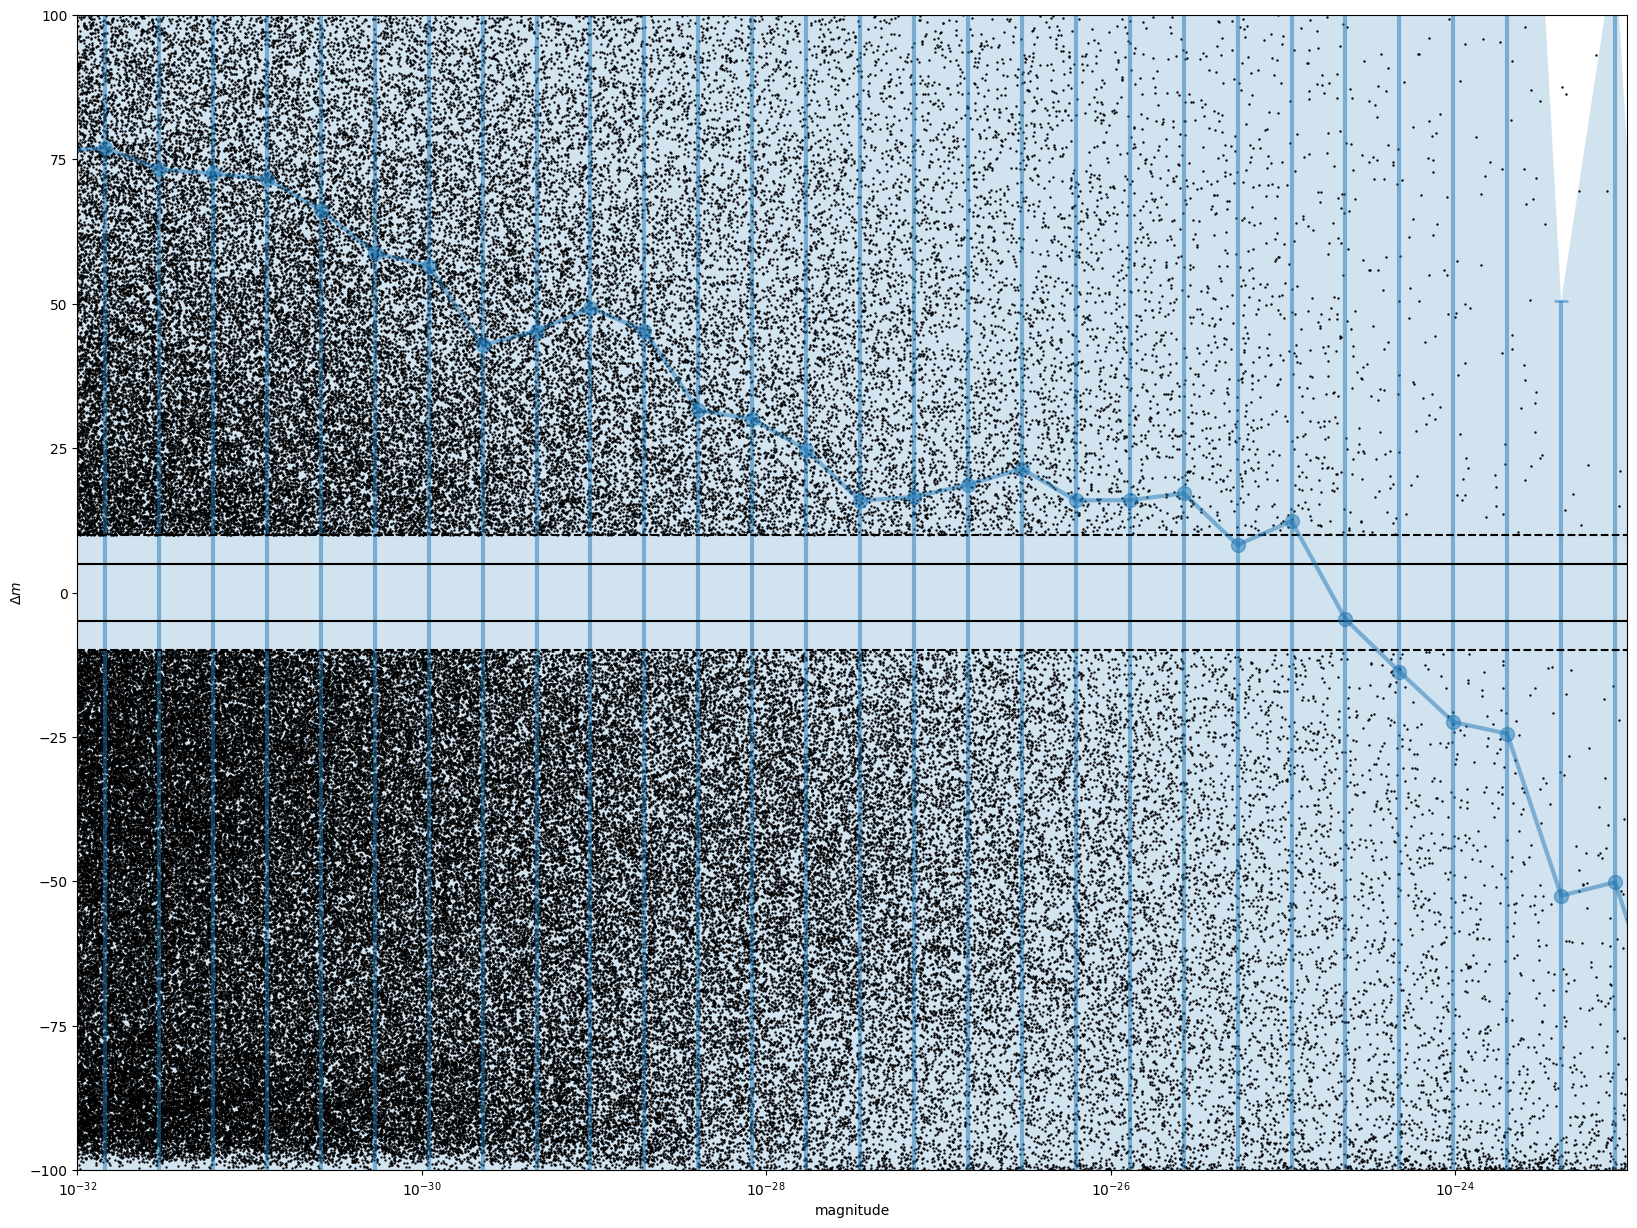

In [7]:
def mab_to_flux(mag):
    return 3.631e-20*10**(-(mag/2.5))


#mag_cut_upper = 30
#mag_cut_lower = 10
#inds = np.where((phot_train[:, 0] < mag_cut_upper) & (phot_train[:, 0] > mag_cut_lower))[0] #UBAND ONLY!!!!!!!!!!!!!!!!!!!!!!

#phot_train = phot_train[inds]
#sps_params_train = sps_params_train[inds, :]

nsamples=1200000
band = 0
#z_train = sps_params_train[:nsamples, 0]
#mass_train = sps_params_train[:nsamples, -1]
#mag = phot_train[:nsamples, band]

#inds = np.where(mass_train > cut(z_train))[0]

#sps_params_train = sps_params_train[inds]
#phot_train = phot_train[inds]

y_bound = 10.0
sps_params = sps_params_train[:nsamples, :]
m_mimic = mab_to_flux(model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0]))
print(sps_params.shape[0])
m_true = mab_to_flux(phot_train[:nsamples, :])
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = ((m_mimic[:, j]-m_true[:, j])/(m_true[:, j]))*100
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', np.logspace(-50, -19, 100))
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', np.logspace(-50, -19, 100))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')
axes2.set_xscale('log')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

axes2.axhline(y=y_bound/2, color='k', linestyle='-')
axes2.axhline(y=-y_bound/2, color='k', linestyle='-')

#axes2.axhline(y=1, color='k', linestyle='-')
#axes2.axhline(y=-1, color='k', linestyle='-')

#axes2.axvline(x=10, color='k', linestyle='--')
#axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-100, 100)

axes2.set_xlim(1e-32, 1e-23)


In [8]:
sps_params_train = np.load("validation_data/sps_parameters_1200000.npy")
phot_train = np.load("validation_data/photometry_1200000.npy")

def cut(z):
    return 10**(z+4)

band = 0

z = sps_params_train[:, 0]
mass = sps_params_train[:, -1]
mag = phot_train[:, band]

inds = np.where(mass > cut(z))[0]

sps_params_train = sps_params_train[inds]
phot_train = phot_train[inds]

total outliers:  63.880841551908496


(-10.0, 4.0)

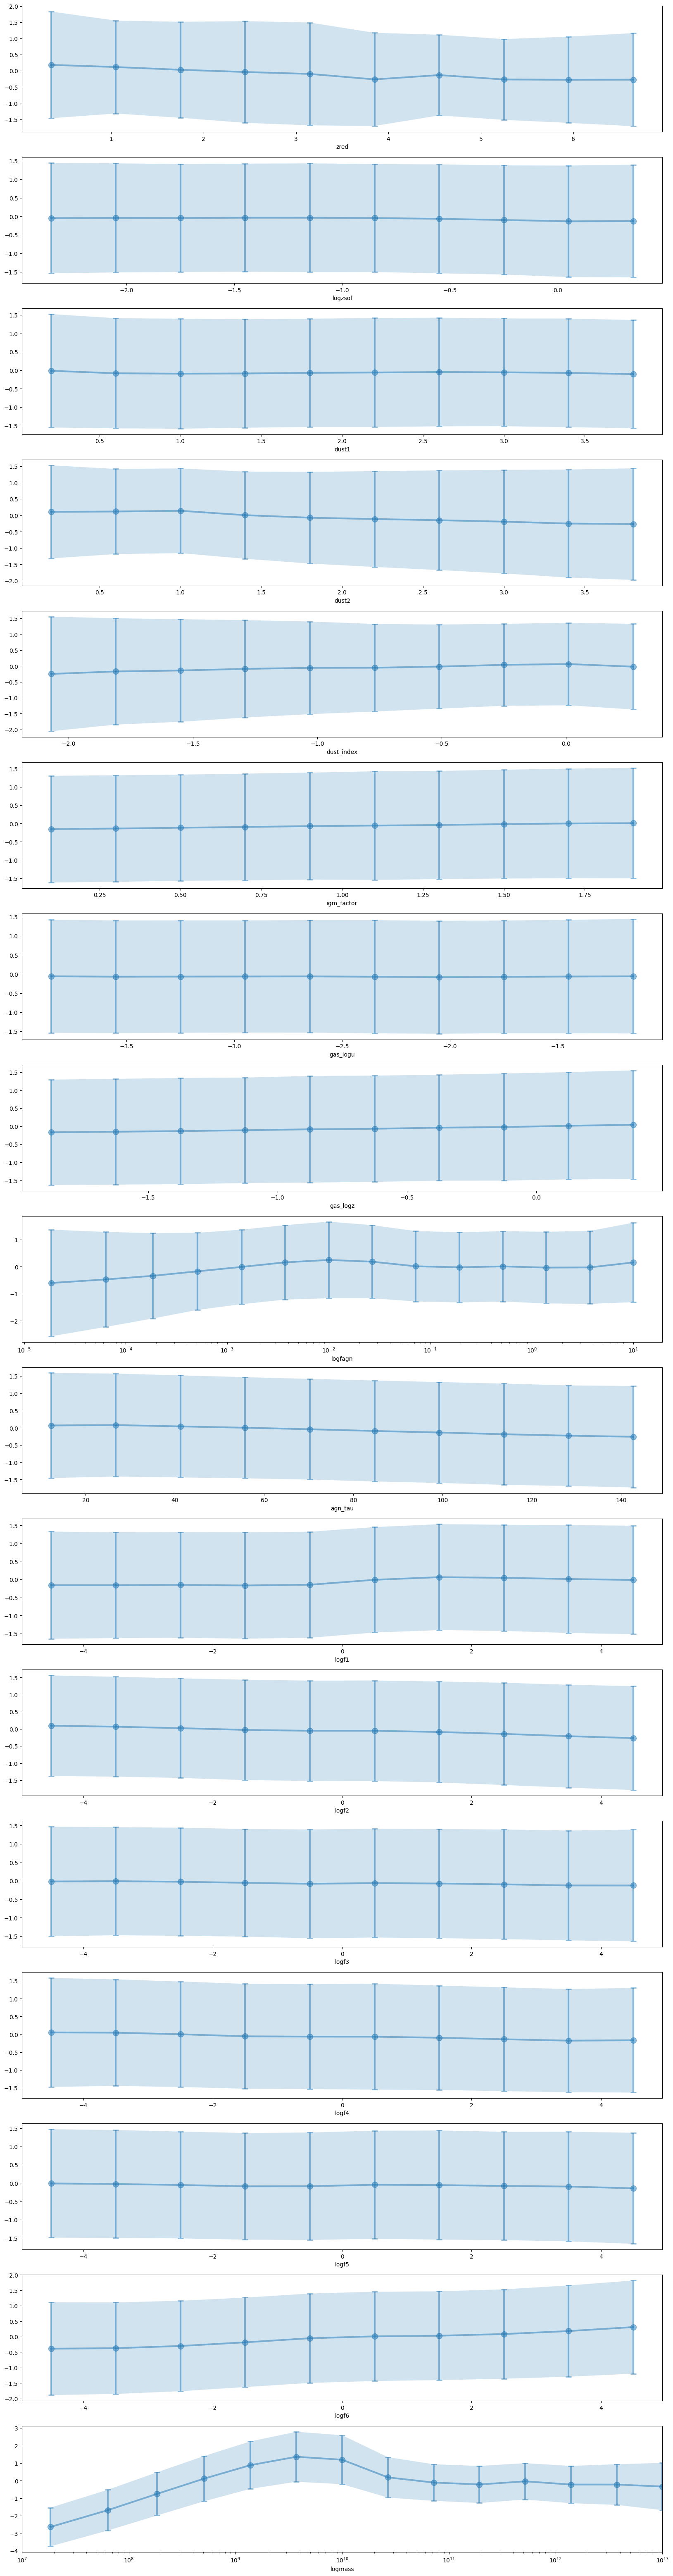

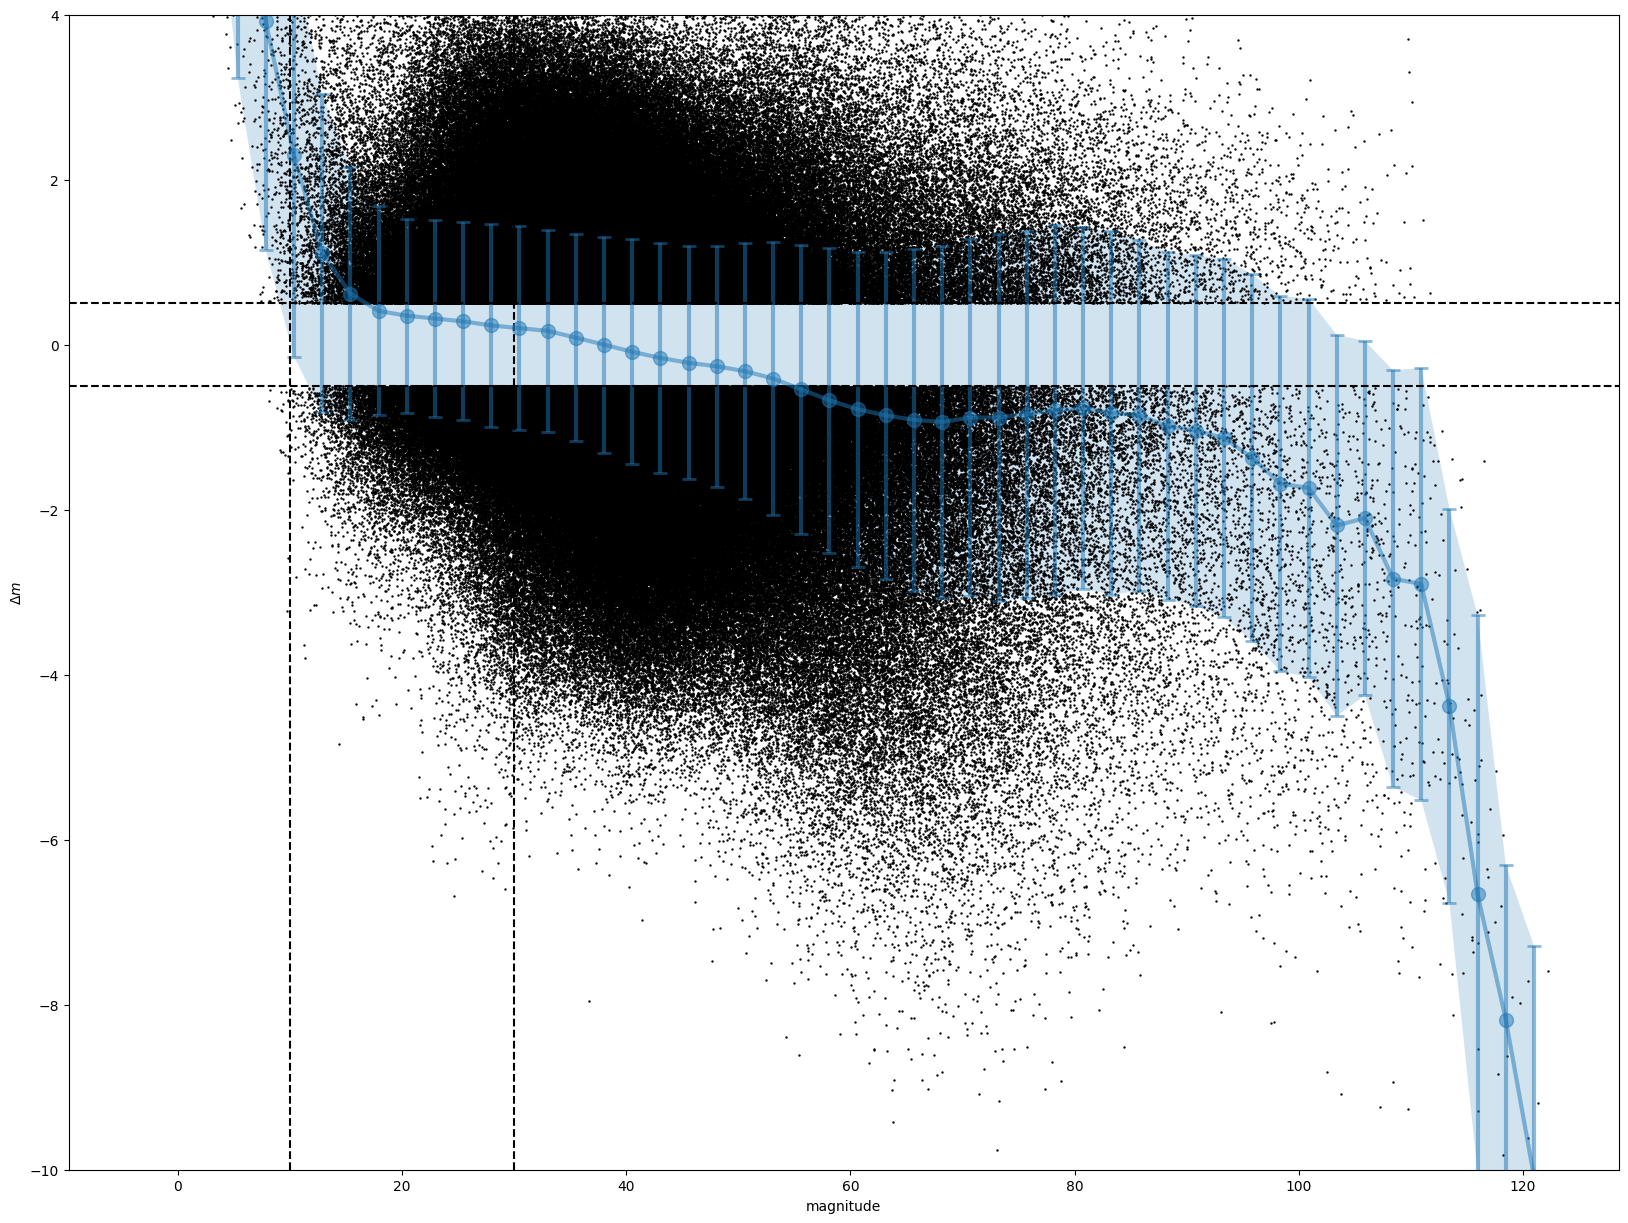

In [9]:
nsamples=1200000
y_bound = 0.5
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,], batch_size=sps_params.shape[0])
m_true = phot_train[:nsamples, :]
nbands = 1 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean', 50)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std', 50)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

    inds = np.where(abs(dm) > y_bound)[0]
    dm_outliers = dm[inds]
    m_true_outliers = m_true[inds, np.ones_like(inds)*j]

    axes2.scatter(m_true[inds, np.ones_like(inds)*j], dm[inds], s=0.5, c='k')
    print("total outliers: ", (len(dm_outliers)/len(dm))*100)



axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')

axes2.axhline(y=y_bound, color='k', linestyle='--')
axes2.axhline(y=-y_bound, color='k', linestyle='--')

#axes2.axhline(y=0.1, color='k', linestyle='-')
#axes2.axhline(y=0.1, color='k', linestyle='-')

axes2.axvline(x=10, color='k', linestyle='--')
axes2.axvline(x=30, color='k', linestyle='--')

axes2.set_ylim(-10, 4)

#axes2.set_xlim(0, 40)


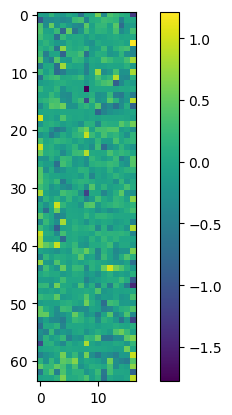

In [10]:
weights = model._models[0].W
biases = model._models[0].b
a = model._models[0].alphas
b = model._models[0].betas

layer = 0

weights[layer].shape

plt.imshow(np.transpose(weights[layer]))
plt.colorbar()

(array([3., 2., 1., 2., 2., 1., 2., 1., 1., 1., 3., 3., 3., 2., 1., 2., 2.,
        5., 3., 2., 3., 3., 0., 5., 4., 3., 6., 4., 1., 4., 4., 4., 7., 3.,
        2., 8., 8., 7., 4., 2., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.]),
 array([-1.83558202, -1.75776052, -1.67993903, -1.60211754, -1.52429605,
        -1.44647455, -1.36865306, -1.29083157, -1.21301007, -1.13518858,
        -1.05736709, -0.97954553, -0.90172404, -0.82390255, -0.74608105,
        -0.66825956, -0.59043807, -0.51261657, -0.43479505, -0.35697356,
        -0.27915207, -0.20133056, -0.12350906, -0.04568757,  0.03213393,
         0.10995543,  0.18777692,  0.26559842,  0.34341991,  0.42124143,
         0.49906293,  0.57688439,  0.65470594,  0.73252743,  0.81034893,
         0.88817042,  0.96599191,  1.04381335,  1.12163496,  1.19945645,
         1.27727795,  1.35509944,  1.43292093,  1.51074243,  1.58856392,
         1.66638541,  1.74420691,  1.8220284 ,  1.89984989,  1.97767138,
         2.05549288]),
 <BarContainer object

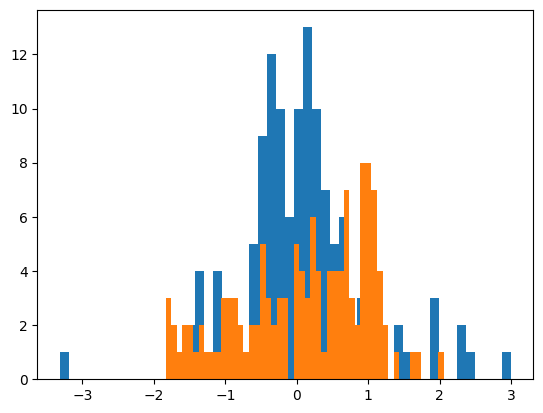

In [11]:
layer = 1

plt.hist(a[layer].numpy(), bins=50)
plt.hist(b[layer].numpy(), bins=50)

#plt.hist(a[layer])

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 3.,
        1., 2., 2., 1., 2., 1., 2., 3., 1., 4., 3., 2., 2., 3., 0., 1., 2.,
        2., 2., 2., 1., 1., 3., 1., 4., 0., 4., 1., 1., 0., 0., 1., 1.]),
 array([-0.74007988, -0.71435761, -0.68863541, -0.66291314, -0.63719088,
        -0.61146867, -0.58574641, -0.56002414, -0.53430194, -0.50857967,
        -0.48285744, -0.45713517, -0.43141294, -0.4056907 , -0.37996846,
        -0.3542462 , -0.32852396, -0.30280173, -0.27707946, -0.25135723,
        -0.22563498, -0.19991274, -0.17419049, -0.14846824, -0.122746  ,
        -0.09702376, -0.07130151, -0.04557927, -0.01985702,  0.00586522,
         0.03158747,  0.05730971,  0.08303196,  0.1087542 ,  0.13447645,
         0.16019869,  0.18592094,  0.21164319,  0.23736542,  0.26308766,
         0.28880993,  0.31453216,  0.3402544 ,  0.36597666,  0.3916989 ,
         0.41742113,  0.4431434 ,  0.46886563,  0.49458787,  0.5203101 ,
         0.54603237]),
 <BarContainer object

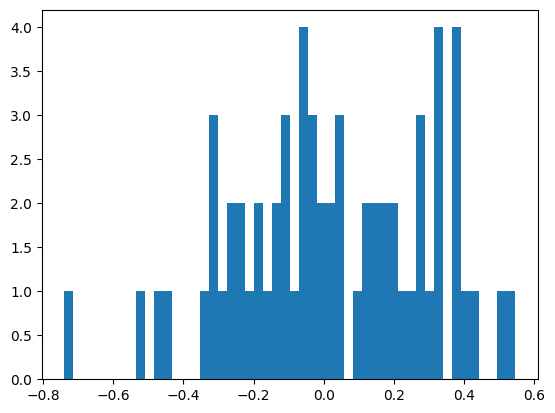

In [12]:
layer = 0

biases[layer].shape
plt.hist(biases[layer].numpy(), bins=50)